In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

In [2]:
test = pd.read_csv('./merchants_test.csv', sep=';')
train = pd.read_csv('./merchants_train.csv', sep=';')
transactions = pd.read_csv('./transactions.csv',  sep=',')

In [3]:
df = pd.merge(transactions, train, on='merchant_id', how='left', suffixes=('_transactions', '_train'))

In [4]:
df.head()

,merchant_id,latitude_transactions,longitude_transactions,real_transaction_dttm,record_date,latitude_train,longitude_train
0,178,0.000000,0.000000,9:34:47,9:30:36,55.055553,82.911833
1,178,55.055995,82.912991,17:49:50,17:54:24,55.055553,82.911833
2,178,0.000000,0.000000,9:34:47,9:31:22,55.055553,82.911833
3,178,55.056034,82.912734,17:49:50,17:43:01,55.055553,82.911833
4,178,55.056034,82.912734,17:49:50,17:45:17,55.055553,82.911833


Посмотрим распределение мерчантов на карте

In [5]:
from mpl_toolkits.basemap import Basemap

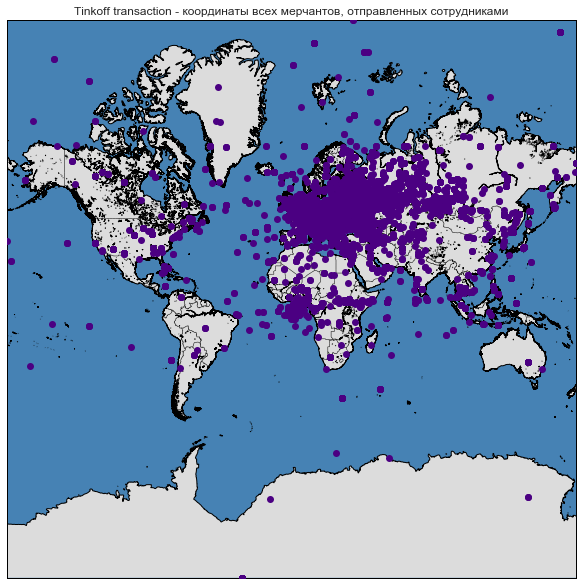

In [6]:
plt.figure(1, figsize=(20,10))
m = Basemap(projection='merc',
             llcrnrlat=df.latitude_transactions.min(),
             urcrnrlat=df.latitude_transactions.max(),
             llcrnrlon=df.longitude_transactions.min(),
             urcrnrlon=df.longitude_transactions.max(),
             lat_ts=0,
             resolution='h')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'gainsboro')
m.drawmapboundary(fill_color='steelblue')
x, y = m(df.longitude_transactions.tolist(), df.latitude_transactions.tolist())
m.plot(x, y, 
            'o',                    # marker shape
            c="indigo", lw=0, alpha=1, zorder=5         # marker size
            )
plt.title("Tinkoff transaction - координаты всех мерчантов, отправленных сотрудниками")
plt.show()

Уберём выбросы на основе данных о реальных координатах мерчантов (содержаться в traine)

In [7]:
df = df[-(df.latitude_transactions>df.latitude_train.max())]
df = df[-(df.latitude_transactions<df.latitude_train.min())]
df = df[-(df.longitude_transactions<df.longitude_train.min())]
df = df[-(df.longitude_transactions>df.longitude_train.max())]

Посмотрим, как соотносятся оправленные сотрудниками координаты мерчантов и реальные координаты этих мерчантов

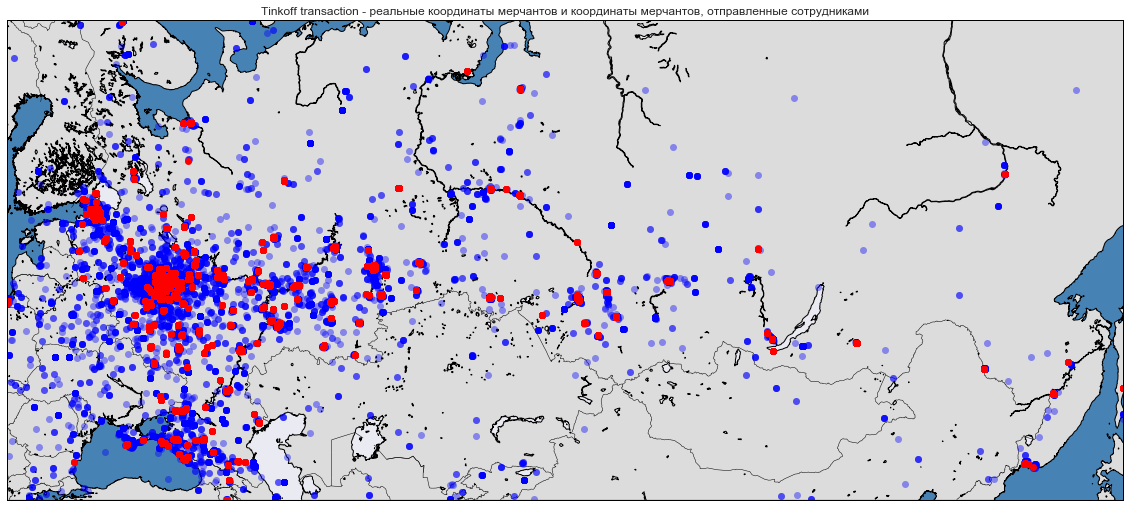

In [8]:
plt.figure(1, figsize=(20,10))
m = Basemap(projection='merc',
             llcrnrlat=df.latitude_transactions.min(),
             urcrnrlat=df.latitude_transactions.max(),
             llcrnrlon=df.longitude_transactions.min(),
             urcrnrlon=df.longitude_transactions.max(),
             lat_ts=0,
             resolution='h')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'gainsboro')
m.drawmapboundary(fill_color='steelblue')
x, y = m(df.longitude_transactions.tolist(), df.latitude_transactions.tolist())
x1, y1 = m(df.longitude_train.tolist(), df.latitude_train.tolist())

m.plot(x, y, 
            'o',                    # marker shape
            c="blue", lw=0, alpha=0.4,         # marker size
            )

m.plot(x1, y1, 
            'o',                    # marker shape
            c="red", lw=0, alpha=1,        # marker size
            )
plt.title("Tinkoff transaction - реальные координаты мерчантов и координаты мерчантов, отправленные сотрудниками")
plt.show()

На данной карте мы видим, что реальные координаты и координаты, отправленные сотрудниками, очень сильно расходятся. Самая простая идея для восстановления геопозиции мерчанта - это взять медиану от всех координат, отправленных для каждого конкретного мерчанта. Собственно, сначала посмотрим, как распределены среднее и медиана для координат мерчантов, которые нам нужно предсказать:

In [10]:
df[df.merchant_id.isin(test.merchant_id)].groupby('merchant_id')[['latitude_transactions','longitude_transactions']].agg([np.mean, np.std, np.median]).head()

latitude_transactions                      longitude_transactions  \
                             mean       std     median                   mean   
merchant_id                                                                     
361                     56.132504  1.215519  55.750347              51.600004   
428                     55.622143  0.079549  55.621785              37.646961   
490                     58.863910  2.090437  59.900721              32.150948   
1175                    55.222014  2.499648  55.738291              37.900483   
1239                    55.779990  0.033850  55.775341              37.567195   

                                   
                   std     median  
merchant_id                        
361          18.420744  37.623851  
428           0.093051  37.664236  
490           3.641455  30.338137  
1175          1.984039  37.602035  
1239          0.070617  37.583508

В качестве ответа берем медиану:

In [11]:
group = df[df.merchant_id.isin(test.merchant_id)].groupby('merchant_id')[['latitude_transactions','longitude_transactions']].agg(np.median)

In [12]:
result = test.join(group, on='merchant_id').drop(['latitude','longitude'], axis=1).fillna(0)

In [143]:
result.to_csv('predict_coord.csv', index=False)